### Make Parsing and Preprocessing Functions

In [1]:
import os

DATA_DIR = os.path.join("english")

In [2]:
next(os.walk(os.path.join(DATA_DIR, 'Durian')))

('english\\Durian',
 [],
 ['aligned.swc',
  'audio.ogg',
  'audiometa.txt',
  'info.json',
  'wiki.html',
  'wiki.txt',
  'wiki.xml'])

In [3]:
# audio = AudioSegment.from_ogg('english/Durian/audio.ogg')
# print(audio.channels, audio.frame_rate)
# swc = SWC('english/Durian/aligned.swc')
# split_clip(audio, swc)

In [4]:
from data_processing import load_utterances

load_utterances(None) # 50 minutes to load 100,000 clips
# print(len(clips))
# clips[0]

Processing file #50, took 21.802432775497437s
Processing file #100, took 60.072611808776855s
Processing file #150, took 98.05257606506348s
Processing file #200, took 143.07693362236023s
Processing file #250, took 187.85582852363586s
Processing file #300, took 235.20872139930725s
Processing file #350, took 296.5718448162079s
Processing file #400, took 364.2879238128662s
Processing file #450, took 417.8420042991638s
Processing file #500, took 472.9900493621826s
Processing file #550, took 537.5792047977448s
Processing file #600, took 607.4178693294525s
Processing file #650, took 655.9610183238983s
Processing file #700, took 703.0443913936615s
Processing file #750, took 753.0098278522491s
Processing file #800, took 810.1027827262878s
Processing file #850, took 862.1634283065796s
Failed to parse file: Fuck_(film) (Decoding failed. ffmpeg returned error code: 3199971767

Output from ffmpeg/avlib:

ffmpeg version 7.0-essentials_build-www.gyan.dev Copyright (c) 2000-2024 the FFmpeg developers


TypeError: object of type 'NoneType' has no len()

In [3]:
from data_processing import load_clips, load_vocab

vocab = load_vocab()
clips = load_clips(vocab=vocab)
# prev: 7 minutes to load 100,000 clips, 9 minutes for 154k clips
# now: 18 mins for 154k
len(clips)

c:\Users\nwong\Documents\nick-repo\.conda\Lib\site-packages\pycochleagram-0.1-py3.11.egg\pycochleagram\erbfilter.py:8: RuntimeWarning: pycochleagram using non-interactive Agg matplotlib backend
  from pycochleagram import utils


Loaded vocabulary vocab.txt with 513 words.


154706

In [3]:
from data_processing import load_utterances, load_vocab

vocab = load_vocab()
load_utterances(None, vocab)

c:\Users\nwong\Documents\nick-repo\.conda\Lib\site-packages\pycochleagram-0.1-py3.11.egg\pycochleagram\erbfilter.py:8: RuntimeWarning: pycochleagram using non-interactive Agg matplotlib backend
  from pycochleagram import utils


Loaded vocabulary vocab.txt with 513 words.
Processing file #50, took 19.971627235412598s
Processing file #100, took 53.221885204315186s
Processing file #150, took 86.25052404403687s
Processing file #200, took 123.46968698501587s
Processing file #250, took 160.63389348983765s
Processing file #300, took 200.92830991744995s
Processing file #350, took 248.91614174842834s
Processing file #400, took 305.7051672935486s
Failed to parse file: Fuck_(film) (Decoding failed. ffmpeg returned error code: 3199971767

Output from ffmpeg/avlib:

ffmpeg version 7.0-essentials_build-www.gyan.dev Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 13.2.0 (Rev5, Built by MSYS2 project)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-w32threads --disable-autodetect --enable-fontconfig --enable-iconv --enable-gnutls --enable-libxml2 --enable-gmp --enable-bzlib --enable-lzma --enable-zlib --enable-libsrt --enable-libssh --enable-libzmq --enable-avisynth --enable-sdl2 --en

#### Specifically Audio Manipulation

In [4]:
from pydub import AudioSegment

from data_processing import gen_clip, overlay_noise

clip = gen_clip(AudioSegment.from_file('parsed_files/raw_clips/government_9302.wav'))
noise = AudioSegment.from_file('audio/outside_rural/snipped119_start_240_end_250.wav')
overlay_noise(2.0, clip, noise)

### Count word frequencies to consider which data points we will keep

{'whiskers': [<matplotlib.lines.Line2D at 0x1b38c24acd0>,
 'caps': [<matplotlib.lines.Line2D at 0x1b390a80e10>,
 'boxes': [<matplotlib.lines.Line2D at 0x1b39c6fbb50>],
 'medians': [<matplotlib.lines.Line2D at 0x1b39fe18510>],
 'fliers': [<matplotlib.lines.Line2D at 0x1b39fe1aa10>],
 'means': []}

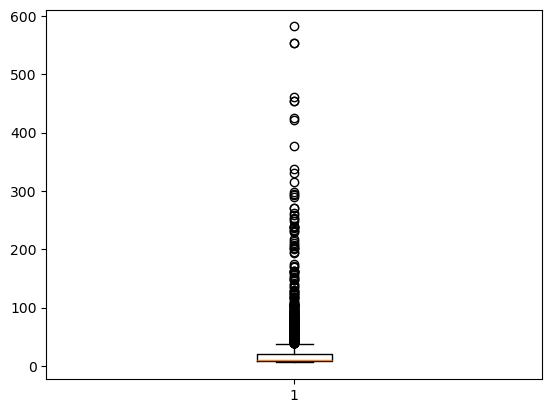

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

freq_dict = {}
for pc in clips:
    freq_dict[pc.word] = freq_dict.get(pc.word, 0) + 1

freqs = list(filter(lambda x: 5 < x < 600, freq_dict.values()))

plt.boxplot(freqs)

In [11]:
wf = dict(filter(lambda x: 30 < x[1] < 500, freq_dict.items()))
print(f'{len(wf)} words remain after filtering')

with open('vocab.txt', 'w') as f:
    f.write("\n".join(wf.keys()))
    print('wrote vocabulary file')

513 words remain after filtering
wrote vocabulary file


In [4]:

from data_processing import filter_clips_vocab, load_vocab

vocab = load_vocab()
filtered_clips = filter_clips_vocab(clips, vocab)
print(len(clips), len(filtered_clips))
clips = filtered_clips

Loaded vocabulary vocab.txt with 513 words.
100283 38055


### Save Audio Files
and overlay noise

In [4]:
import os

from data_processing import make_noise_playlist

music_clips = make_noise_playlist(os.path.join('audio', 'music'), 200)
outdoor_clips = make_noise_playlist(os.path.join('audio', 'outside_rural'))
babble_clips = make_noise_playlist(os.path.join('audio', 'babble'))

In [5]:
m_path = os.path.join('parsed_files', 'music')
o_path = os.path.join('parsed_files', 'outdoor')
b_path = os.path.join('parsed_files', 'babble')

os.makedirs(m_path, exist_ok = True)
os.makedirs(o_path, exist_ok = True)
os.makedirs(b_path, exist_ok = True)

In [5]:
from data_processing import load_clips

clips = load_clips()
len(clips)

In [17]:
from data_processing import load_vocab

vocab = load_vocab()
clips = list(filter(lambda c: c.word in vocab, clips))
len(clips)

Loaded vocabulary vocab.txt with 513 words.


38055

In [11]:
import random
from typing import List

from pydub import AudioSegment

from data_processing import PronunciationClip


def equalize_clip_nums(clips: List[PronunciationClip], vocab: List[str],
                       minimum: int = 300) -> List[PronunciationClip]:
    cc = [list(filter(lambda c: c.word == w, clips)) for w in vocab]
    for clps in cc:
        if len(clps) >= minimum:
            continue
        word = clps[0].word
        N = len(clps)
        for i in range(minimum - N):
            offset = round((random.random() * 200))
            clip = AudioSegment.silent(duration=2000, frame_rate=16_000)
            clip.set_channels(1).set_sample_width(4)
            new_clip = clip.overlay(clps[i % N].audio, offset)
            if new_clip.rms == 0:
                print('Exception:', word, i, offset)
                # raise Exception("Clip still silent")
                continue
            new_clip.export(f'parsed_files/raw_clips/{word}_synth_{i}.wav',
                            format='wav')
            clips.append(PronunciationClip(word, new_clip))

In [12]:
n = len(clips)
equalize_clip_nums(clips, vocab)
n, len(clips)

Exception: between 32 101
Exception: forty 2 186
Exception: never 7 49
Exception: never 44 13
Exception: never 81 87
Exception: never 118 47
Exception: never 155 70
Exception: never 192 166
Exception: never 229 178


(46799, 154770)

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(1, test_size=513, random_state=42)
clip_ind, _ = next(sss.split(clips, list(map(lambda c: c.word, clips))))
clip_ind, len(clip_ind)

(array([ 39998,  42606,  45511, ..., 113511,  12595,  64837], dtype=int64),
 154193)

In [7]:
import numpy as np

clips = np.array(clips)[clip_ind]

In [8]:
clips[:5], len(clips)

(array([PronunciationClip('eventually', <pydub.audio_segment.AudioSegment object at 0x000002D534490550>),
        PronunciationClip('famous', <pydub.audio_segment.AudioSegment object at 0x000002D550FD7F50>),
        PronunciationClip('film', <pydub.audio_segment.AudioSegment object at 0x000002D56EB04B50>),
        PronunciationClip('peter', <pydub.audio_segment.AudioSegment object at 0x000002D70AAD7490>),
        PronunciationClip('version', <pydub.audio_segment.AudioSegment object at 0x000002D8890EC9D0>)],
       dtype=object),
 154193)

#### Overlay into Specific SNRs

In [21]:
import random
import time
from concurrent.futures import ThreadPoolExecutor

# import numpy as np
from data_processing import overlay_noise_clips

# music is -6dB mean, other noise is -3dB mean. all with 2dB variance
# np.random.seed(123)
N = len(clips)
# N = 6000
# music_snr = np.random.normal(-6, 2, N)
# outdoor_snr = np.random.normal(-3, 2, N)
# babble_snr = np.random.normal(-3, 2, N)

m_path = os.path.join('parsed_files_snrs', 'music')
o_path = os.path.join('parsed_files_snrs', 'outdoor')
b_path = os.path.join('parsed_files_snrs', 'babble')

os.makedirs(m_path, exist_ok = True)
os.makedirs(o_path, exist_ok = True)
os.makedirs(b_path, exist_ok = True)

random.seed(123)
starttime = time.time()
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(
        overlay_noise_clips,
        clip,
        [
            random.choice(music_clips),
            random.choice(outdoor_clips),
            random.choice(babble_clips)
        ],
        [-12.0, -6.0, -3.0, 0.0, 2.0, 6.0, 12.0],
        [m_path, o_path, b_path],
        i, starttime
    ) for i, clip in enumerate(clips[:N])]

c:\Users\nwong\Documents\nick-repo\data_processing.py:234: RuntimeWarning: invalid value encountered in cast
  np.round(noise_samples).astype(np.int32))
c:\Users\nwong\Documents\nick-repo\.conda\Lib\site-packages\pycochleagram-0.1-py3.11.egg\pycochleagram\cochleagram.py:135: RuntimeWarning: divide by zero encountered in log10
  freqs_to_plot = np.log10(freqs)


Parsing 200-th file, 3056.9641239643097s since start.
Parsing 400-th file, 6122.908997774124s since start.
Parsing 600-th file, 9531.52306675911s since start.
Parsing 800-th file, 12828.536994695663s since start.
Parsing 1000-th file, 15957.581048965454s since start.
Parsing 1200-th file, 19038.297805309296s since start.
Parsing 1400-th file, 22226.666455984116s since start.
Parsing 1600-th file, 25360.508534669876s since start.
Parsing 1800-th file, 28567.080582141876s since start.
Parsing 2000-th file, 31678.20028400421s since start.
Parsing 2200-th file, 34750.80649423599s since start.
Parsing 2400-th file, 37879.794107437134s since start.
Parsing 2600-th file, 41065.7208673954s since start.
Parsing 2800-th file, 44195.21884703636s since start.
Parsing 3000-th file, 47303.23667526245s since start.
Parsing 3200-th file, 50499.80161643028s since start.
Parsing 3400-th file, 53650.61767745018s since start.
Parsing 3600-th file, 56873.32995700836s since start.
Parsing 3800-th file, 5988

#### Overlay as McDermott Lab

In [9]:
import random
import time
from concurrent.futures import ThreadPoolExecutor

import numpy as np

from data_processing import make_word2ind, overlay_noise_clip

# music is -6dB mean, other noise is -3dB mean. all with 2dB variance
np.random.seed(123)
N = len(clips)
music_snr = np.random.normal(-6, 2, N)
outdoor_snr = np.random.normal(-3, 2, N)
babble_snr = np.random.normal(-3, 2, N)

# word2ind = make_word2ind(clips)

random.seed(123)
starttime = time.time()

# split_clips = np.array_split(clips, 70_000)
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(
        overlay_noise_clip,
        clip,
        # word2ind,
        [
            random.choice(music_clips),
            random.choice(outdoor_clips),
            random.choice(babble_clips)
        ],
        [music_snr[i], outdoor_snr[i], babble_snr[i]],
        [m_path, o_path, b_path],
        i, starttime
    ) for i, clip in enumerate(clips)]

c:\Users\nwong\Documents\nick-repo\data_processing.py:235: RuntimeWarning: invalid value encountered in cast
  np.round(noise_samples).astype(np.int32))
c:\Users\nwong\Documents\nick-repo\.conda\Lib\site-packages\pycochleagram-0.1-py3.11.egg\pycochleagram\cochleagram.py:135: RuntimeWarning: divide by zero encountered in log10
  freqs_to_plot = np.log10(freqs)


Parsing 200-th file, 881.100921869278s since start.
Parsing 400-th file, 1793.1833710670471s since start.
Parsing 600-th file, 2723.9741559028625s since start.
Parsing 800-th file, 3622.9441118240356s since start.
Parsing 1000-th file, 4554.153605222702s since start.
Parsing 1200-th file, 5464.139996051788s since start.
Parsing 1400-th file, 6373.347545146942s since start.
Parsing 1600-th file, 7306.948763370514s since start.
Parsing 1800-th file, 8238.464520454407s since start.
Parsing 2000-th file, 9119.055095911026s since start.
Parsing 2200-th file, 10020.629117965698s since start.
Parsing 2400-th file, 10943.439545631409s since start.
Parsing 2600-th file, 11825.269472837448s since start.
Parsing 2800-th file, 12728.460972309113s since start.
Parsing 3000-th file, 13629.224338293076s since start.
Parsing 3200-th file, 14525.558368206024s since start.
Parsing 3400-th file, 15455.98648238182s since start.
Parsing 3600-th file, 16365.658656835556s since start.
Parsing 3800-th file, 1

In [20]:
split_clips[0][5]
overlay_noise_clips(split_clips[0], word2ind,
        [
            random.choice(music_clips),
            random.choice(outdoor_clips),
            random.choice(babble_clips)
        ],
        [-6, -3, -3],
        [m_path, o_path, b_path],
        0)

ValueError: operands could not be broadcast together with shapes (160000,) (515,) 

In [25]:
c = split_clips[0][0]
c

PronunciationClip('critics', <pydub.audio_segment.AudioSegment object at 0x00000261983080D0>)

In [26]:
len(clips)

154779

### Load Data
Load audio files functions, vocabulary, word-to-index dictionary, cochleagrams

In [18]:
from data_processing import load_clips

clips = load_clips()
vocab = load_vocab()

Loaded vocabulary vocab.txt with 237 words.


In [13]:
from data_processing import make_word2ind

word2ind = make_word2ind(clips)
print(f'{len(word2ind)} words from {len(clips)} clips')
word2ind

513 words from 154266 clips


{'very': 0,
 'this': 1,
 'hall': 2,
 'ship': 3,
 'despite': 4,
 'more': 5,
 'located': 6,
 'about': 7,
 'until': 8,
 'award': 9,
 'death': 10,
 'district': 11,
 'western': 12,
 'popular': 13,
 'success': 14,
 'peter': 15,
 'commonly': 16,
 'greek': 17,
 'computer': 18,
 'william': 19,
 'people': 20,
 'notable': 21,
 'title': 22,
 'since': 23,
 'hundred': 24,
 'research': 25,
 'queen': 26,
 'writing': 27,
 'august': 28,
 'million': 29,
 'bush': 30,
 'water': 31,
 'power': 32,
 'lake': 33,
 'control': 34,
 'office': 35,
 'originally': 36,
 'members': 37,
 'home': 38,
 'john': 39,
 'york': 40,
 'story': 41,
 'because': 42,
 'political': 43,
 'primary': 44,
 'eventually': 45,
 'lost': 46,
 'company': 47,
 'church': 48,
 'east': 49,
 'part': 50,
 'another': 51,
 'seventy': 52,
 'seventeen': 53,
 'region': 54,
 'radio': 55,
 'fifteen': 56,
 'site': 57,
 'project': 58,
 'released': 59,
 'group': 60,
 'september': 61,
 'often': 62,
 'eight': 63,
 'term': 64,
 'into': 65,
 'natural': 66,
 'cent

In [1]:
from data_processing import load_vocab, vocab_word2ind

vocab = load_vocab()
word2ind = vocab_word2ind(vocab)
# load_cochleagrams('parsed_files/babble', word2ind)

Loaded vocabulary vocab.txt with 513 words.


c:\Users\nwong\Documents\nick-repo\.conda\Lib\site-packages\pycochleagram-0.1-py3.11.egg\pycochleagram\erbfilter.py:8: RuntimeWarning: pycochleagram using non-interactive Agg matplotlib backend
  from pycochleagram import utils


## Train/Test Split

In [2]:
import numpy as np

from data_processing import load_cochleagrams

X = np.zeros([0,256,256])
T = np.zeros([0])

x, t = load_cochleagrams('parsed_files/babble', word2ind, limit=28_000)
# x, t = load_cochleagrams('parsed_files/babble', word2ind)
X = np.append(X, x, axis=0)
T = np.append(T, t, axis=0)
x, t = load_cochleagrams('parsed_files/music', word2ind, limit=28_000)
# x, t = load_cochleagrams('parsed_files/music', word2ind)
X = np.append(X, x, axis=0)
T = np.append(T, t, axis=0)
x, t = load_cochleagrams('parsed_files/outdoor', word2ind, limit=28_000)
# x, t = load_cochleagrams('parsed_files/outdoor', word2ind)
X = np.append(X, x, axis=0)
T = np.append(T, t, axis=0)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'parsed_files/babble'

In [2]:
import numpy as np
import os
import random
from data_processing import load_vocab, vocab_word2ind

x = [os.listdir('parsed_files/babble'), os.listdir('parsed_files/music'), os.listdir('parsed_files/outdoor')]
# paths = ['parsed_files/babble', 'parsed_files/music', 'parsed_files/outdoor']
noise_type = ['babble', 'music', 'outdoor']
[random.shuffle(y) for y in x]
BATCHES = 400
N = min(len(y) for y in x)
word2ind = vocab_word2ind(load_vocab())

n = N // BATCHES
for i in range(360, BATCHES):
    # X = []
    T = []
    for k in range(len(x)):
        X = []
        noise = noise_type[k]
        path = f'parsed_files/{noise}'
        for j in range(n*i, n*(i+1)):
            f = x[k][j]
            w = f.split('_')[0]
            if not f.endswith('.npy') or w not in word2ind:
                continue
            X.append(np.load(f'{path}/{f}'))
            T.append(word2ind[w])
        np.save(f'model_train/inputs_{noise}_{i}.npy', X)
        np.save(f'model_train/targets_{noise}_{i}.npy', T)
    # np.save(f'model_train/inputs_{i}.npy', X)
    # np.save(f'model_train/targets_{i}.npy', T)

Loaded vocabulary vocab.txt with 513 words.


In [ ]:
X.shape, T.shape

((84000, 256, 256), (84000,))

In [ ]:
del x
del t

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, T, test_size=0.1,
                                                    random_state=1234)

In [ ]:
import os

import numpy as np

os.makedirs('model_train/train', exist_ok=True)
os.makedirs('model_train/test', exist_ok=True)

np.save('model_train/train/inputs.npy', X_train)
np.save('model_train/train/targets.npy', y_train)
np.save('model_train/test/inputs.npy', X_test)
np.save('model_train/test/targets.npy', y_test)

OSError: 659554304 requested and 0 written